In [1]:
!pip install fair-esm
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch 
from torch import nn
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.nn.functional import cross_entropy, mse_loss, cosine_similarity
import esm
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
# ── Config ──
MAX_LEN       = 512
BATCH_SIZE    = 64
LATENT_DIM    = 256
EMB_DIM       = 256
NUM_LAYERS    = 4
NUM_HEADS     = 4
FFN_DIM       = 512
DROPOUT       = 0.3

LR_PHASE1     = 5e-4    # higher LR for CE‐only warmup
LR_PHASE2     = 1e-4    # later LR

EPOCHS_PHASE1 = 100      # CE‐only for first 20 epochs
TOTAL_EPOCHS  = 500

CE_WEIGHT1    = 100.0    # CE weight during phase1
CE_WEIGHT2    = 1.0     # CE weight afterwards
KL_WEIGHT     = 0.1
COS_WEIGHT    = 5.0
MSE_WEIGHT    = 5.0
class SequenceDataset(Dataset):
    def __init__(self, seqs, alphabet, max_len=MAX_LEN):
        self.seqs     = seqs
        self.alphabet = alphabet
        self.max_len  = max_len

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx][:self.max_len]
        ids = [self.alphabet.get_idx(c) for c in seq]
        return torch.tensor(ids, dtype=torch.long)

def collate_fn(batch):
    # pad to max length in batch
    lengths = [len(x) for x in batch]
    L = max(lengths)
    padded = torch.full((len(batch), L), PAD_IDX, dtype=torch.long)
    mask   = torch.zeros(len(batch), L, dtype=torch.bool)
    for i, x in enumerate(batch):
        padded[i, :len(x)] = x
        mask[i, :len(x)]   = True
    return padded.to(DEVICE), mask.to(DEVICE)
import torch 
from torch import nn
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.nn.functional import cross_entropy, mse_loss, cosine_similarity
import esm
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

# ── Config ──
MAX_LEN       = 512
BATCH_SIZE    = 64
LATENT_DIM    = 256
EMB_DIM       = 256
NUM_LAYERS    = 4
NUM_HEADS     = 4
FFN_DIM       = 512
DROPOUT       = 0.3

LR_PHASE1     = 5e-4    # higher LR for CE‐only warmup
LR_PHASE2     = 1e-4    # later LR

EPOCHS_PHASE1 = 100      # CE‐only for first 20 epochs
TOTAL_EPOCHS  = 500

CE_WEIGHT1    = 100.0    # CE weight during phase1
CE_WEIGHT2    = 1.0     # CE weight afterwards
KL_WEIGHT     = 0.1
COS_WEIGHT    = 5.0
MSE_WEIGHT    = 5.0

class ProteinDataset(Dataset):
    def __init__(self, sequences, alphabet):
        self.sequences = [seq[:MAX_LEN] for seq in sequences]
        self.alphabet  = alphabet

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        idxs = [self.alphabet.get_idx(c) for c in self.sequences[idx]]
        return torch.tensor(idxs, dtype=torch.long)

def collate_fn(batch, pad_idx):
    padded = pad_sequence(batch, batch_first=True, padding_value=pad_idx)
    mask   = (padded != pad_idx)
    return padded, mask
    
class SmallTransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim, layers, heads, ffn_dim, max_len, pad_idx):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.pos = nn.Parameter(torch.zeros(1, max_len, emb_dim))
        layer   = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=heads,
            dim_feedforward=ffn_dim, batch_first=True,
            activation='gelu', dropout=DROPOUT
        )
        self.enc = nn.TransformerEncoder(layer, layers)
        self.ln  = nn.LayerNorm(emb_dim)

    def forward(self, x):
        mask = x != self.emb.padding_idx
        h    = self.emb(x) + self.pos[:, :x.size(1), :]
        h    = self.enc(h, src_key_padding_mask=~mask)
        return self.ln(h), mask

class BigTransformer(SmallTransformer):
    pass  # identical API

# ── Single‐stage VAE ──
class VAETransformerDecoder(nn.Module):
    def __init__(self, encoder, vocab_size, latent_dim=LATENT_DIM,
                 emb_dim=EMB_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS,
                 ffn_dim=FFN_DIM, max_len=MAX_LEN, pad_token=0, bos_token=1):
        super().__init__()
        self.encoder   = encoder
        self.pad_token = pad_token
        self.bos_token = bos_token

        # latent heads
        self.to_mu     = nn.Linear(emb_dim, latent_dim)
        self.to_logvar = nn.Linear(emb_dim, latent_dim)
        self.latent2emb= nn.Linear(latent_dim, emb_dim)

        # decoder
        self.dec_emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_token)
        self.dec_pos = nn.Parameter(torch.zeros(1, max_len, emb_dim))
        layer = nn.TransformerDecoderLayer(
            d_model=emb_dim, nhead=num_heads,
            dim_feedforward=ffn_dim, dropout=DROPOUT,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(layer, num_layers)
        self.out     = nn.Linear(emb_dim, vocab_size)

    def forward(self, x, mask):
        # encode
        h_enc, enc_mask = self.encoder(x)
        pooled = (h_enc * enc_mask.unsqueeze(-1)).sum(1) / enc_mask.sum(1, True)
        mu, logvar = self.to_mu(pooled), self.to_logvar(pooled)
        z = mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)

        # prepare decoder input
        B, L = x.size()
        dec_in = torch.full((B, L), self.bos_token, device=x.device, dtype=torch.long)
        dec_in[:,1:] = x[:,:-1]
        emb = self.dec_emb(dec_in) + self.dec_pos[:, :L, :]
        z_emb = self.latent2emb(z).unsqueeze(1).expand(-1, L, -1)
        emb = emb + z_emb

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(L).to(x.device)
        h_dec = self.decoder(
            tgt=emb,
            memory=h_enc,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=~mask,
            memory_key_padding_mask=~enc_mask
        )
        logits = self.out(h_dec)
        return logits, mu, logvar, h_enc, enc_mask

# load alphabet & teacher
import esm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
PAD_IDX     = alphabet.get_idx('<pad>')
BOS_IDX     = alphabet.get_idx('<cls>')
enc = BigTransformer(
        len(alphabet.all_toks), EMB_DIM, NUM_LAYERS, NUM_HEADS, FFN_DIM, MAX_LEN, PAD_IDX
    ).to(device)
vae = VAETransformerDecoder(
        encoder=enc,
        vocab_size=len(alphabet.all_toks),
        latent_dim=LATENT_DIM,
        emb_dim=EMB_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS,
        ffn_dim=FFN_DIM, max_len=MAX_LEN,
        pad_token=PAD_IDX, bos_token=BOS_IDX
    ).to(device)
#vae = nn.DataParallel(vae)
# ── 0) Config ──
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT  = "/kaggle/input/esms-vae/pytorch/default2/1/vae_epoch380.pt"
noise_scale = 0.2   # tweak as needed
ckpt = torch.load(CHECKPOINT, map_location=device)
vae.load_state_dict(ckpt["model_sd"])
vae.to(device).eval()
print('loaded vae')

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


loaded vae


In [3]:
import pandas as pd
df=pd.read_csv('/kaggle/input/gfp-set/classified_proteins_output.csv')
print(len(df))
df

354


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Name,Ex max (nm),Em max (nm),Stokes Shift (nm),Extinction Coefficient,Quantum Yield,Brightness,pKa,Oligomerization,Maturation (min),Lifetime (ns),Molecular Weight (kDa),Switch Type,Aliases,Sequence,Sequence_Clean,Cluster,Color
0,mStayGold2,499.0,509.0,10.0,175000,0.79,138.25,4.80,m,NaN,2.83,26.49,b,QC2-6(PT),MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Cyan/Green
1,mStayGold,499.0,510.0,11.0,164000,0.83,136.12,4.80,m,NaN,2.79,25.58,b,QC2-6 FIQ,MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Cyan/Green
2,StayGold-E138D,497.0,504.0,7.0,145000,0.87,126.15,4.60,m,14.0,NaN,24.60,b,mStayGold,MASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGKYVCTSGKLP...,MASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGKYVCTSGKLP...,0,Cyan/Green
3,mBaoJin,500.0,508.0,8.0,128000,0.93,119.04,4.37,m,7.6,3.10,26.58,b,"mBJ, mStayGold",MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Green/Yellow
4,mBaoJin-T55S,497.0,508.0,11.0,127000,0.86,109.22,NaN,m,NaN,NaN,26.56,b,mBJ-T55S,MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,MVSKGEEENMASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGK...,0,Cyan/Green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,ShG24,486.0,506.0,20.0,-,NaN,NaN,NaN,m,NaN,NaN,26.96,b,NaN,MSKGEELFTGVVPILVELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,MSKGEELFTGVVPILVELDGDVHGHKFSVRGEGEGDADYGKLEIKF...,0,Cyan/Green
350,Slow-FT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,m,NaN,NaN,26.79,t,NaN,MVSKGEEDNMAIIKEFMRFKVHVEGSVNGHEFEIVGEGEGRPYEGT...,MVSKGEEDNMAIIKEFMRFKVHVEGSVNGHEFEIVGEGEGRPYEGT...,0,Unknown
351,SuperfoldermTurquoise2,434.0,474.0,40.0,-,NaN,NaN,NaN,m,NaN,NaN,26.85,b,sfTq2,MVSKGEELFT GVVPILVELD GDVNGHKFSV RGEGEGDATN GK...,MVSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLK...,0,Blue/Cyan
352,SuperfoldermTurquoise2ox,434.0,474.0,40.0,-,NaN,NaN,NaN,m,NaN,NaN,26.84,b,sfTq2ox,MVSKGEELFT GVVPILVELD GDVNGHKFSV RGEGEGDATN GK...,MVSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLK...,0,Blue/Cyan


In [4]:
from Bio import SeqIO
seq_path='/kaggle/input/uniref50-sub/uniref50_subsample.fasta'
sequences=[]
for seq_record in SeqIO.parse(seq_path, "fasta"):
    sequences.append(str(seq_record.seq))
print(len(sequences))

1000000


In [5]:
sequences=sequences[:700]

In [7]:
df=df[['Ex max (nm)','Em max (nm)','Sequence_Clean']]

In [6]:
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import joblib
import os
import esm
_, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

# ── CONFIGURATION ──
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_LEN    = 512
BATCH_SIZE = 32
RANDOM_SEED = 42

# ── ASSUMED VARIABLES ──
# df        : pandas DataFrame with ['Sequence_Clean','Ex max (nm)','Em max (nm)', …]
# neg_seqs  : list of non-fluorescent sequence strings
# alphabet  : ESM alphabet object
# vae       : pretrained VAE model with .encoder(x) -> (reps, mask)

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

vae = vae.to(device)
batch_converter = alphabet.get_batch_converter()

# ── 1) LABEL & UNDERSAMPLE ──
df = df.copy()
df['fluorescent'] = df['Ex max (nm)'].notnull().astype(int)
pos_df = df[df['fluorescent']==1].copy()

ratio     = 2
neg_sample = random.sample(sequences, len(pos_df)*ratio)
neg_df = pd.DataFrame({
    'Sequence_Clean': neg_sample,
    'Ex max (nm)':    np.nan,
    'Em max (nm)':    np.nan,
    'fluorescent':    0
})

all_df = pd.concat([
    pos_df[['Sequence_Clean','Ex max (nm)','Em max (nm)','fluorescent']],
    neg_df
], ignore_index=True)

idx       = np.arange(len(all_df))
idx_train, idx_test = train_test_split(
    idx, test_size=0.2,
    stratify=all_df['fluorescent'],
    random_state=RANDOM_SEED
)
train_df = all_df.iloc[idx_train].reset_index(drop=True)
test_df  = all_df.iloc[idx_test].reset_index(drop=True)

# ── 2) DATASET & DATALOADER ──
class SeqDataset(Dataset):
    def __init__(self, df):
        self.seqs   = df['Sequence_Clean'].tolist()
        self.labels = df['fluorescent'].values
        self.abs    = df['Ex max (nm)'].fillna(0.0).values
        self.em     = df['Em max (nm)'].fillna(0.0).values

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        _, _, arr = batch_converter([("id", seq)])
        token_ids = arr[0].clone().detach().long()
        return token_ids, self.labels[idx], self.abs[idx], self.em[idx]

def pad_collate_fn(batch):
    seqs, labels, abs_vals, em_vals = zip(*batch)
    pad_idx = alphabet.get_idx('<pad>')
    processed = []
    for s in seqs:
        if s.size(0) > MAX_LEN:
            s_proc = s[:MAX_LEN]
        else:
            pad = torch.full((MAX_LEN - s.size(0),), pad_idx, dtype=torch.long)
            s_proc = torch.cat([s, pad], dim=0)
        processed.append(s_proc)
    seq_tensor = torch.stack(processed, dim=0)
    return seq_tensor, torch.tensor(labels), torch.tensor(abs_vals), torch.tensor(em_vals)

train_loader = DataLoader(SeqDataset(train_df), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=pad_collate_fn)
test_loader  = DataLoader(SeqDataset(test_df),  batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate_fn)

# ── 3) EXTRACT Z USING VAE ──
def extract_Z(loader):
    vae.eval()
    Z_list, y_f, y_a, y_e = [], [], [], []
    with torch.no_grad():
        for seq_batch, lbl, abs_v, em_v in loader:
            seq_batch = seq_batch.to(device)
            reps, mask = vae.encoder(seq_batch)
            mask = mask.unsqueeze(-1)
            reps = reps * mask.float()
            summed = reps.sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1)
            z = (summed / counts).cpu().numpy()
            Z_list.append(z)
            y_f.extend(lbl.tolist())
            y_a.extend(abs_v.tolist())
            y_e.extend(em_v.tolist())
    return np.vstack(Z_list), np.array(y_f), np.array(y_a), np.array(y_e)

Z_train, y_f_train, y_abs_train, y_em_train = extract_Z(train_loader)
Z_test,  y_f_test,  y_abs_test,  y_em_test  = extract_Z(test_loader)

# ── 4) TRAIN GP CLASSIFIER ──
kernel_cls = ConstantKernel(1.0,(1e-3,1e3)) * RBF(1.0,(1e-2,1e2))
gpc        = GaussianProcessClassifier(kernel=kernel_cls, max_iter_predict=200)
gpc.fit(Z_train, y_f_train)
auc = cross_val_score(gpc, Z_train, y_f_train, cv=5, scoring='roc_auc').mean()
print(f"GPC 5‐fold AUC: {auc:.3f}")

# ── 5) TRAIN GP REGRESSORS ──
kernel_reg = ConstantKernel(1.0,(1e-3,1e3)) * RBF(1.0,(1e-2,1e2))
gpr_abs    = GaussianProcessRegressor(kernel=kernel_reg, alpha=1e-6, normalize_y=True)
gpr_em     = GaussianProcessRegressor(kernel=kernel_reg, alpha=1e-6, normalize_y=True)

y_abs_all = np.where(y_f_train==1, y_abs_train, 0.0)
y_em_all  = np.where(y_f_train==1, y_em_train,  0.0)

gpr_abs.fit(Z_train, y_abs_all)
gpr_em.fit(Z_train,  y_em_all)

rmse_abs = np.sqrt(((gpr_abs.predict(Z_train) - y_abs_all)**2).mean())
rmse_em  = np.sqrt(((gpr_em.predict(Z_train)  - y_em_all )**2).mean())
print(f"Train RMSE λ_abs: {rmse_abs:.2f}, λ_em: {rmse_em:.2f}")

# ── 6) SAVE MODELS ──
os.makedirs('saved_models', exist_ok=True)
torch.save(vae.encoder.state_dict(),              'saved_models/vae_encoder.pth')
joblib.dump(gpc,      'saved_models/gpc_fluorescence.pkl')
joblib.dump(gpr_abs,  'saved_models/gpr_absorption.pkl')
joblib.dump(gpr_em,   'saved_models/gpr_emission.pkl')
print("Models saved to ./saved_models/")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10

GPC 5‐fold AUC: 0.987


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Train RMSE λ_abs: 2.70, λ_em: 3.80
Models saved to ./saved_models/


In [18]:
from sklearn.metrics import classification_report
import pandas as pd

# 1) 예측
y_train_pred = gpc.predict(Z_train)
y_test_pred  = gpc.predict(Z_test)

# 2) 리포트 생성 (dict → DataFrame)
train_report = classification_report(y_f_train, y_train_pred, output_dict=True)
test_report  = classification_report(y_f_test,  y_test_pred,  output_dict=True)

train_df = pd.DataFrame(train_report).transpose().round(4)
test_df  = pd.DataFrame(test_report).transpose().round(4)

# 3) 컬럼 그룹별로 합치기
comparison = pd.concat(
    {'Train': train_df, 'Test': test_df}, 
    axis=1
)

print(comparison)


                 Train                                 Test                   \
             precision  recall f1-score   support precision  recall f1-score   
0               0.9938  0.9661   0.9798  501.0000    0.9837  0.9680   0.9758   
1               0.9356  0.9880   0.9611  250.0000    0.9385  0.9683   0.9531   
accuracy        0.9734  0.9734   0.9734    0.9734    0.9681  0.9681   0.9681   
macro avg       0.9647  0.9770   0.9704  751.0000    0.9611  0.9681   0.9645   
weighted avg    0.9745  0.9734   0.9735  751.0000    0.9686  0.9681   0.9682   

                        
               support  
0             125.0000  
1              63.0000  
accuracy        0.9681  
macro avg     188.0000  
weighted avg  188.0000  


In [12]:
from sklearn.metrics import classification_report
# predict
y_pred = gpc.predict(Z_test)
# print text report
print(classification_report(y_f_test, y_pred, digits=4))
import pandas as pd
from sklearn.metrics import classification_report

# get dict, turn into DataFrame
report_dict = classification_report(y_f_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

              precision    recall  f1-score   support

           0     0.9840    0.9840    0.9840       125
           1     0.9683    0.9683    0.9683        63

    accuracy                         0.9787       188
   macro avg     0.9761    0.9761    0.9761       188
weighted avg     0.9787    0.9787    0.9787       188



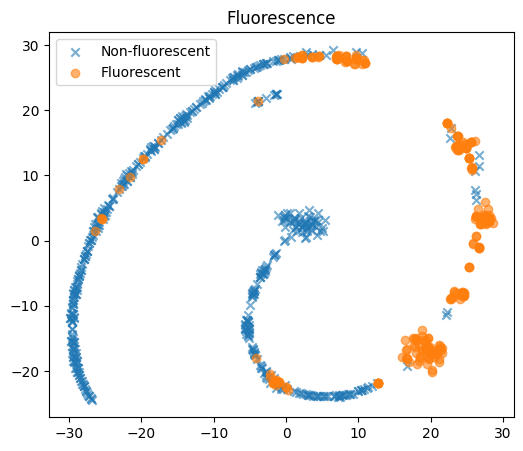

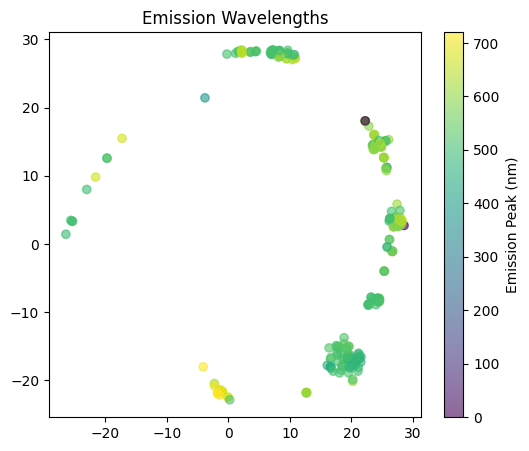

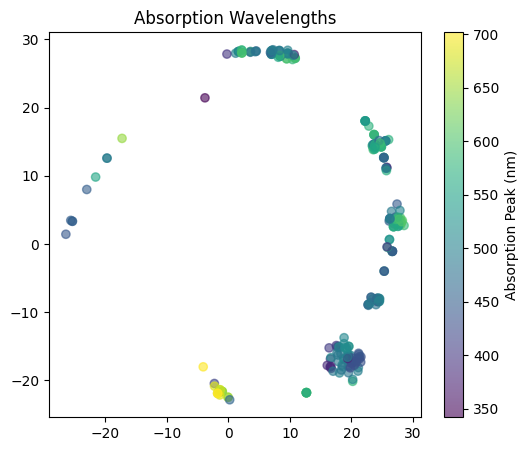

In [9]:
# 1) Re-import and redefine everything
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Recreate train_loader, ensure vae, alphabet, DEVICE, pad_collate_fn are defined
# e.g. train_loader = DataLoader(...)

# Redefine extract_Z if needed
def extract_Z(loader):
    vae.eval()
    Z_list, y_f, y_a, y_e = [], [], [], []
    with torch.no_grad():
        for seq_batch, lbl, abs_v, em_v in loader:
            seq_batch = seq_batch.to(DEVICE)
            reps, mask = vae.encoder(seq_batch)
            mask = mask.unsqueeze(-1).float()
            summed = (reps * mask).sum(1)
            counts = mask.sum(1).clamp(min=1)
            z = (summed / counts).cpu().numpy()
            Z_list.append(z)
            y_f.extend(lbl.tolist())
            y_a.extend(abs_v.tolist())
            y_e.extend(em_v.tolist())
    return np.vstack(Z_list), np.array(y_f), np.array(y_a), np.array(y_e)

# 2) Extract data again
#Z_train, y_f_train, y_abs_train, y_em_train = extract_Z(train_loader)

# 3) TSNE + plotting as before
tsne = TSNE(n_components=2, random_state=42)
Z2d = tsne.fit_transform(Z_train)

# Fluorescence mask
mask_non = (y_f_train == 0)
mask_fluor = (y_f_train == 1)

# Plot 1
plt.figure(figsize=(6,5))
plt.scatter(Z2d[mask_non,0], Z2d[mask_non,1], marker='x', alpha=0.6, label='Non-fluorescent')
plt.scatter(Z2d[mask_fluor,0], Z2d[mask_fluor,1], marker='o', alpha=0.6, label='Fluorescent')
plt.legend(); plt.title('Fluorescence'); plt.show()

# Plot 2
plt.figure(figsize=(6,5))
plt.scatter(Z2d[mask_fluor,0], Z2d[mask_fluor,1], c=y_em_train[mask_fluor], alpha=0.6)
plt.colorbar(label='Emission Peak (nm)'); plt.title('Emission Wavelengths'); plt.show()

# Plot 3
plt.figure(figsize=(6,5))
plt.scatter(Z2d[mask_fluor,0], Z2d[mask_fluor,1], c=y_abs_train[mask_fluor], alpha=0.6)
plt.colorbar(label='Absorption Peak (nm)'); plt.title('Absorption Wavelengths'); plt.show()


In [19]:
import torch
import joblib
import numpy as np
from torch.utils.data import Dataset, DataLoader

# ── 0. 설정 ──
DEVICE   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_LEN  = 512
PAD_IDX  = alphabet.get_idx('<pad>')
BOS_IDX  = alphabet.get_idx('<cls>')
BATCH    = 32

# ── 1. VAE 인코더 로드 ──
# (여기서는 vae 클래스를 이미 정의했다고 가정)
vae = vae                     # VAE 모델 클래스 생성자 호출
#vae.encoder.load_state_dict(torch.load('saved_models/vae_encoder.pth', map_location=DEVICE))
vae = vae.to(DEVICE).eval()

# ── 2. GP 모델 로드 ──
gpc     = joblib.load('/kaggle/input/fp_regressor/scikitlearn/default/1/saved_models/gpc_fluorescence.pkl')
gpr_abs = joblib.load('/kaggle/input/fp_regressor/scikitlearn/default/1/saved_models/gpr_absorption.pkl')
gpr_em  = joblib.load('/kaggle/input/fp_regressor/scikitlearn/default/1/saved_models/gpr_emission.pkl')

# ── 3. 예측용 유틸 함수 ──
class PredictDataset(Dataset):
    def __init__(self, seqs, alphabet):
        self.seqs = seqs
        self.batch_converter = alphabet.get_batch_converter()
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, idx):
        _, _, arr = self.batch_converter([("id", self.seqs[idx])])
        return arr[0].clone().detach().long()

def pad_collate_predict(batch):
    processed = []
    for s in batch:
        L = s.size(0)
        if L > MAX_LEN:
            s_proc = s[:MAX_LEN]
        else:
            pad = torch.full((MAX_LEN - L,), PAD_IDX, dtype=torch.long)
            s_proc = torch.cat([s, pad], dim=0)
        processed.append(s_proc)
    return torch.stack(processed, dim=0)

def predict_fluorescence_and_peaks(seqs):
    # 1) 시퀀스 → latent Z
    ds     = PredictDataset(seqs, alphabet)
    loader = DataLoader(ds, batch_size=BATCH, collate_fn=pad_collate_predict)
    Z_list = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            reps, mask = vae.encoder(batch)
            mask = mask.unsqueeze(-1).float()
            summed = (reps * mask).sum(1)
            counts = mask.sum(1).clamp(min=1)
            z = (summed / counts).cpu().numpy()
            Z_list.append(z)
    Z = np.vstack(Z_list)

    # 2) 분류 및 회귀 예측
    probs    = gpc.predict_proba(Z)[:,1]
    preds    = (probs >= 0.5).astype(int)
    pred_abs = gpr_abs.predict(Z)
    pred_em  = gpr_em.predict(Z)
    pred_abs = np.where(preds==1, pred_abs, 0.0)
    pred_em  = np.where(preds==1, pred_em,  0.0)

    return probs, preds, pred_abs, pred_em

# ── 4. 사용 예 ──
new_seqs = [
    "MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGKYVCTSGKLPMSWAALGTSFGYGMKYYTKYPSGLKNWFHEVMPEGFTYDRHIQYKGDGSIHAKHQHFMKNGTYHNIVEFTGQDFKENSPVLTGDMDVSLPNEVQHIPRDDGVECTVTLTYPLLSDESKCVEAYQNTIIKPLHNQPAPDVPYHWIRKQYTQSKDDTEERDHIIQSETLEAHLYSRTKLE",
    "MVSTGEELFTGVVPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGKYVCTSGKLPMSWAALGTSFGYGMKYYTKYPSGLKNWFHEVMPEGFTYDRHIQYKGDGSIHAKHQHFMKNGTYHNIVEFTGQDFKENSPVLTGDMDVSLPNEVQHIPRDDGVECTVTLTYPLLSDESKCVEAYQNTIIKPLHNQPAPDVPYHWIRKQYTQSKDDTEERDHIIQSETLEAHLYSRTKLE",
    "MASTPFKFQLKGTINGKSFTVEGEGEGNSHEGSHKGKYVCTSGKLPMSWAALGTSFGYGMKYYTKYPSGLKNWFHEVMPEGFTYDRHIQYKGDGSIHAKHQHFMKNGTYHNIVEFTGQDFKENSPVLTGDMNVSLPNDVQHIPRDDGVECPVTLLYPLLSDKSKCVEAHQNTICKPLHNQPAPDVPYHWIRKQYTQSKDDTEERDHICQSETLEAHL",
    "MVSKGEELIKENMHTKLYMEGTVNNHHFKCTHEGEGKPYEGTQTNRIKVVEGGPLPFAFDILATCFMYGSKTFINHTQGIPDFFKQSFPEGFTWERVTTYEDGGVLTVTQDTSLQDGCLIYNVKLRGVNFPSNGPVMQKKTLGWEASTETLYPADGGLEGRCDMALKLVGGGHLHCNLKTTYRSKKPAKNLKMPGVYFVDRRLERIKEADNETYVEQHEVAVARYCDLPSKLGH",
    "MVSKGEELIKENMHMKLYMEGTVNNHHFKCTTEGEGKPYEGTQTQRIKVVEGGPLPFAFDILATCFMYGSKTFINHTQGIPDFFKQSFPEGFTWERVTTYEDGGVLTVTQDTSLQDGCLIYNVKLRGVNFPSNGPVMQKKTLGWEATTETLYPADGGLEGRCDMALKLVGGGHLHCNLKTTYRSKKPAKNLKMPGVYFVDRRLERIKEADNETYVEQHEVAVARYCDLPSKLGH",
    "MVSKGEELIKENMHMKLYMEGTVNNHHFKCTSEGEGKPYEGTQTGRIKVVEGGPLPFAFDILATCFMYGSKTFINHTQGIPDFFKQSFPEGFTWERVTTYEDGGVLTVTQDTSLQDGCLIYNVKLRGVNFPSNGPVMQKKTLGWEASTETLYPADGGLEGRCDMALKLVGGGHLHCNLKTTYRSKKPAKNLKMPGVYFVDRRLERIKEADNETYVEQHEVAVARYCDLPSKLGH",
    "MVSKGEELIKENMHMKLYMEGTVNNHHFKCTSEGEGKPYEGTQTGRIKVVEGGPLPFAFDILATCFMYGSKTFINHTQGIPDFFKQSFPEGFTWERVTTYEDGGVLTATQDTSLQDGCLIYNVKIRGVNFPSNGPVMQKKTLGWEASTETLYPADGGLEGRCDMALKLVGGGHLICNLKTTYRSKKPAKNLKMPGVYFVDRRLERIKEADKETYVEQHEVAVARYCDLPSKLGH",
    "MVSKGEELIKENMHTKLYLTGTVNNHYFECTAEGEGKPYEGTQTNRIKVVRGGPLPFAFDILAPCFMYGSKTFINHPPDIPDYFKQSFPEGFTWERTTVYEDGGTLTATQDTSLQDGCLIYNVQVRGENFPSNGPVMQKKTLGWEASTETLYPADGSLEGRLDWALKLVGGGHLHCRLETTYRSKKPAKNLKMPGVYFIDRRLERIKEADNETYVEQHEVAVARYCDLPSKLGH",
    "MVSKGEELIKENMHMKLYMEGTVNNHHFKCTSEGEGKPYEGTQTQRIKVVEGGPLPFAFDILATSFMYGSKTFINHTQGIPDFFKQSFPEGFTWERVTTYEDGGVLKVKQDTSLQDGCLIYNVKIRGVNFPSNGPVMQKKTLGWEANTETLYPADGGLRGYNTMALKLVGGGHLQTFLKTTYRSKKPAKNLKMPGVYFVDRRLERIKEADKETYVEQHEVAVARYCDLPSKLGH",
    "MVSKGEELIKENMHMKLYMEGTVNNHHFKCTSEGEGKPYEGTQTQRIKVVEGGPLPFAFDILATCFMYGSKTFINHTQGIPDFFKQSFPEGFTWERVTTYEDGGVLTATQDTSLQDGCLIYNVKIRGVNFPSNGPVMQKKTLGWEANTETLYPADGGLRGHNQMALKLVGGGHLICNLKTTYRSKKPAKNLKMPGVYFVDRRLERIKEADKETYVEQHEVAVARYCDLPSKLGH",
    "MVSKGEELIKENMHMKLYMEGTVNNHHFKCTSEGEGKPYEGTQTQRIKVVEGGPLPFAFDILATCFMYGSKTFINHTQGIPDFFKQSFPEGFTWERVTTYEDGGVLTATQDTSLQDGCLIYNVKIRGVNFPSNGPVMQKKTLGWEANTETLYPADGGLRGHNPMALKLVGGGHLICNLKTTYRSKKPAKNLKMPGVYFVDRRLERIKEADKETYVEQHEVAVARYCDLPSKLGH"  
]
seq0=['MARKVDLTSCDREPIHIPGSIQPCGCLLACDAQAVRITRITENAGAFFGRETPRVGELLADYFGETEAHALRNALAQSSDPKRPALIFGWRDGLTGRTFDISLHRHDGTSIIEFEPAAAEQADNPLRLTRQIIARTKELKSLEEMAARVPRYLQAMLGYHRVMLYRFADDGSGMVIGEAKRSDLESFLGQHFPASLVPQQARLLYLKNAIRVVSDSRGISSRIVPEHDASGAALDLSFAHLRSISPCHLEFLRNMGVSASMSLSIIIDGTLWGLIICHHYEPRAVPMAQRVAAKRFAERLSTHFTAAHHQR',]

probs, preds, ex_max, em_max = predict_fluorescence_and_peaks(seq0)
preds=[True if p==1 else False for p in preds]

print('class 0')
for seq, p, y, ex, em in zip(seq0, probs, preds, ex_max, em_max):
    print(f"{seq[:10]}... → P(fluor)={p:.3f}, pred={y}, Ex={ex:.1f}nm, Em={em:.1f}nm")
print()
seq2=['MANLDKMLNTTVTEVRKFLQADRVCVFKFEEDYSGTVSHEAVDDRWISILKTQVQDRYFMETRGEEYVHGRYQAIADIYTANLVECYRDLLIEFQVRAILAVPILQGKKLWGLLVAHQ',
      'MEHVAFGSEDIENTLAKMDDGQLDGLAFGAIQLDGDGNILQYNAAEGDITGRDPKQVIGKNLFKDVAPGTVSSGFYGKFKEGVASGNLNTMFEWMIPTSRGPTKVKIHMKKALSGDSY',
     'MANLDKMLNTTVTEVRQFLQVDRVCVFQFEEDYSGVVVVEAVDDRWISILKTQVRDRYFMETRGEEYSHGRYQAIADIYTANLTECYRDLLTQFQVRAILAVPILQGKKLWGLLVAHQ',
     'MPRISDKLMKTRWRGFHSIPSIPPDLGGIYGIGEKTSRRKTTEHLYTGRAKDIKSRLMKHKYGHQAIDRKIRSNIKQKKLSDLRFKFVEERNHKAKEGLAIEGLKKKLGYAPRFNLRK',
     'MEHVAFGSEDIENTLANMDDEQLDRLAFGVIQLDGDGNILLYNAAEGDITGRDPKQVIGKNFFKDVAPGTDTPEFYGKFKEGAASGNLNTMFEWTIPTSRGPTKVKVHLKKALSGDRY']

probs, preds, ex_max, em_max = predict_fluorescence_and_peaks(new_seqs)
preds=[True if p==1 else False for p in preds]
print('class 1, beta barrel sequence')
for seq, p, y, ex, em in zip(new_seqs, probs, preds, ex_max, em_max):
    print(f"{seq[:10]}... → P(fluor)={p:.3f}, pred={y}, Ex={ex:.1f}nm, Em={em:.1f}nm")
print()
probs, preds, ex_max, em_max = predict_fluorescence_and_peaks(seq2)
print('class 2')
preds=[True if p==1 else False for p in preds]

for seq, p, y, ex, em in zip(seq2, probs, preds, ex_max, em_max):
    print(f"{seq[:10]}... → P(fluor)={p:.3f}, pred={y}, Ex={ex:.1f}nm, Em={em:.1f}nm")

class 0
MARKVDLTSC... → P(fluor)=0.704, pred=True, Ex=175.9nm, Em=252.5nm

class 1, beta barrel sequence
MVSTGEELFT... → P(fluor)=0.987, pred=True, Ex=252.4nm, Em=494.0nm
MVSTGEELFT... → P(fluor)=0.987, pred=True, Ex=252.4nm, Em=494.0nm
MASTPFKFQL... → P(fluor)=0.879, pred=True, Ex=497.0nm, Em=504.0nm
MVSKGEELIK... → P(fluor)=0.991, pred=True, Ex=361.6nm, Em=476.2nm
MVSKGEELIK... → P(fluor)=0.992, pred=True, Ex=346.0nm, Em=468.5nm
MVSKGEELIK... → P(fluor)=0.991, pred=True, Ex=385.9nm, Em=501.3nm
MVSKGEELIK... → P(fluor)=0.991, pred=True, Ex=404.2nm, Em=527.5nm
MVSKGEELIK... → P(fluor)=0.953, pred=True, Ex=305.1nm, Em=419.1nm
MVSKGEELIK... → P(fluor)=0.993, pred=True, Ex=417.5nm, Em=546.0nm
MVSKGEELIK... → P(fluor)=0.990, pred=True, Ex=390.0nm, Em=525.0nm
MVSKGEELIK... → P(fluor)=0.990, pred=True, Ex=394.6nm, Em=524.5nm

class 2
MANLDKMLNT... → P(fluor)=0.147, pred=False, Ex=0.0nm, Em=0.0nm
MEHVAFGSED... → P(fluor)=0.480, pred=False, Ex=0.0nm, Em=0.0nm
MANLDKMLNT... → P(fluor)=0.171, pr